#### Кандидат: Алихан Алашыбай

**Задание #1** Анализ финансовых транзакций и клиентов

In [116]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

print('Библиотеки загружены: Done')

Библиотеки загружены: Done


##### 1) Dataset import

In [82]:
# Транзакции
tx_raw = pd.read_excel('./dataset/Transactions Data.xlsx')
print(f'Транзакции: {tx_raw.shape[0]:,} строк × {tx_raw.shape[1]} колонок')
tx_raw.head()

Транзакции: 10,000 строк × 8 колонок


,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer
3,524031ea-56e2-410a-aee2-e8fc6ae3fbc5,NaN,2025-03-02 03:14:10,Финансовое планирование,2313.980219,Неизвестно,Erichaven,Patricia Haas
4,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena


In [83]:
# Клиенты
with open('./dataset/Clients Data.json', encoding='utf-8') as f:
    cl_raw = pd.DataFrame(json.load(f))

cl_raw.rename(columns={'id': 'client_id'}, inplace=True)
print(f'Клиенты: {cl_raw.shape[0]:,} строк × {cl_raw.shape[1]} колонок')
cl_raw.head()

Клиенты: 9,799 строк × 4 колонок


,client_id,age,gender,net_worth
0,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,41.0,Мужчина,2514729.46
1,c940f45c-d29b-439a-8fa3-f75018cef528,28.0,Мужчина,566568.29
2,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,55.0,Женщина,1896001.28
3,NaN,38.0,Женщина,4538759.60
4,3f43d7bc-37f0-4535-8391-51702d6ff81e,31.0,Мужчина,4865849.92


##### 2) Data Exploration

In [87]:
print('Транзакции(Dataset): ')
print(tx_raw.dtypes.to_string())
print('\nПропуски:')
print(tx_raw.isnull().sum().to_string())

Транзакции(Dataset): 
transaction_id          str
client_id               str
transaction_date     object
service                 str
amount              float64
payment_method          str
city                    str
consultant              str

Пропуски:
transaction_id      474
client_id           202
transaction_date      0
service               0
amount              460
payment_method        0
city                  0
consultant            0


In [88]:
print('Клиенты(Dataset): ')
print(cl_raw.dtypes.to_string())
print('\nПропуски:')
print(cl_raw.isnull().sum().to_string())

Клиенты(Dataset): 
client_id        str
age          float64
gender           str
net_worth    float64

Пропуски:
client_id       1
age           983
gender       3319
net_worth     475


In [90]:
print('Уникальные услуги:', tx_raw['service'].unique().tolist())
print('\nСпособы оплаты:', tx_raw['payment_method'].unique().tolist())
print('\nСтатистика по amount:')
print(tx_raw['amount'].describe().round(2).to_string())

Уникальные услуги: ['Структурирование капитала', 'Финансовое планирование', 'Инвестиционное консультирование', 'Неизвестная услуга', 'Налоговое планирование', 'Управление активами']

Способы оплаты: ['Банковский перевод', 'Неизвестно', 'Кредитная карта', 'Криптовалюта', 'Наличные']

Статистика по amount:
count      9540.00
mean      49246.78
std       37962.00
min          14.04
25%       19074.84
50%       41651.71
75%       71378.89
max      277442.16


##### 3) Data Cleaning

In [94]:
# Очистка Транзакции
tx = tx_raw.copy()

# 1. Привести даты к единому формату datetime
tx['transaction_date'] = pd.to_datetime(tx['transaction_date'], errors='coerce')

log = {}

# 2. Удалить строки с некорректными датами (NaT после coerce)
bad_dates = tx['transaction_date'].isna().sum()
tx = tx.dropna(subset=['transaction_date'])
log['Некорректные даты'] = bad_dates

# 3. Удалить строки с пропущенными ключевыми полями
before = len(tx)
tx = tx.dropna(subset=['transaction_id', 'client_id', 'amount'])
log['Пропуски ключевых полей'] = before - len(tx)

# 4. Удалить отрицательные и нулевые суммы
before = len(tx)
tx = tx[tx['amount'] > 0]
log['Нулевые/отрицательные суммы'] = before - len(tx)

# 5. Удалить аномальные категории
before = len(tx)
tx = tx[tx['service'] != 'Неизвестная услуга']
tx = tx[tx['payment_method'] != 'Неизвестно']
log['Аномальные категории'] = before - len(tx)

# 6. Дедупликация по transaction_id
before = len(tx)
tx = tx.drop_duplicates(subset=['transaction_id'])
log['Дубликаты'] = before - len(tx)

print('Статистика очистки транзакций:')
for k, v in log.items():
    print(f'  {k:<35}: удалено {v}')
print(f'\nИтого: {len(tx):,} строк')

Статистика очистки транзакций:
  Некорректные даты                  : удалено 1005
  Пропуски ключевых полей            : удалено 983
  Нулевые/отрицательные суммы        : удалено 0
  Аномальные категории               : удалено 1520
  Дубликаты                          : удалено 0

Итого: 6,492 строк


In [93]:
# Очистка клиентов
cl = cl_raw.copy()
before = len(cl)
cl = cl.dropna(subset=['client_id', 'net_worth'])
cl = cl[cl['age'].notna() & (cl['age'] > 0)]
cl = cl.drop_duplicates(subset=['client_id'])
print(f'Клиентов после очистки: {len(cl):,} (удалено {before - len(cl)})')
cl.describe().round(2)

Клиентов после очистки: 8,376 (удалено 1423)


,age,net_worth
count,8376.00,8376.00
mean,40.06,2498035.98
std,11.82,1427674.85
min,20.00,10213.97
25%,30.00,1263024.49
50%,40.00,2484122.16
75%,50.00,3717874.80
max,60.00,4999428.12


#### 4) Анализ транзакций

In [96]:
# Топ-5 услуг по количеству транзакций
top5 = (tx['service']
        .value_counts()
        .head(5)
        .rename_axis('service')
        .reset_index(name='count'))
print('Топ-5 услуг: ')
print(top5.to_string(index=False))

Топ-5 услуг: 
                        service  count
Инвестиционное консультирование   1774
            Управление активами   1446
        Финансовое планирование   1110
         Налоговое планирование   1091
      Структурирование капитала   1071


In [97]:
# Средняя сумма транзакций по городам (топ-20)
avg_city = (tx.groupby('city')['amount']
            .mean()
            .sort_values(ascending=False)
            .round(2)
            .head(20)
            .rename_axis('city')
            .reset_index(name='avg_amount'))
print('Топ-20 городов по среднему чеку: ')
print(avg_city.to_string(index=False))

Топ-20 городов по среднему чеку: 
              city  avg_amount
  East Rachelmouth    56842.44
     Michellehaven    55345.60
   New Zacharyport    55313.82
  North Lauriebury    55006.75
  New Tommyborough    54457.82
Port Michellemouth    54197.92
       Krystalland    54074.14
         Kaneburgh    53675.58
         Patelbury    53495.57
       Trevinoberg    53134.98
      South Andrew    51809.69
          Bondstad    51806.68
 North Melissaland    51765.99
         Erichaven    51361.57
         Lake Tina    51157.71
      Hamiltontown    50953.92
          Mayoberg    50748.13
        Port James    50716.88
 East Matthewmouth    50540.49
       Johnsonfort    50439.24


In [99]:
# Выручка по услугам
rev_svc = (tx.groupby('service')['amount']
           .sum()
           .sort_values(ascending=False)
           .round(2)
           .rename_axis('service')
           .reset_index(name='total_revenue'))
print('Выручка по услугам: ')
print(rev_svc.to_string(index=False))
print(f'\nЛидер: {rev_svc.iloc[0]["service"]} ({rev_svc.iloc[0]["total_revenue"]:,.0f})')

Выручка по услугам: 
                        service  total_revenue
Инвестиционное консультирование    88981192.41
            Управление активами    70751003.48
        Финансовое планирование    55789706.11
         Налоговое планирование    53801676.33
      Структурирование капитала    52330699.23

Лидер: Инвестиционное консультирование (88,981,192)


In [100]:
# Доля транзакций по способу оплаты
pay_share = (tx['payment_method']
             .value_counts(normalize=True)
             .mul(100).round(2)
             .rename_axis('payment_method')
             .reset_index(name='share_%'))
print('Способы оплаты: ')
print(pay_share.to_string(index=False))

Способы оплаты: 
    payment_method  share_%
   Кредитная карта    44.35
Банковский перевод    38.62
          Наличные    11.06
      Криптовалюта     5.98


In [102]:
# Выручка за последний месяц
last_period = tx['transaction_date'].dt.to_period('M').max()
mask_last   = tx['transaction_date'].dt.to_period('M') == last_period
print(f'Последний месяц: {last_period}')
print(f'Транзакций: {mask_last.sum():,}')
print(f'Выручка: {tx.loc[mask_last, "amount"].sum():,.2f}')

Последний месяц: 2025-03
Транзакций: 1,599
Выручка: 79,631,001.53


#### 5) Merge with clients

In [103]:
merged = tx.merge(cl, on='client_id', how='left')
print(f'Строк после merge: {len(merged):,}  |  Без совпадения: {merged["net_worth"].isna().sum():,}')
merged.head(3)

Строк после merge: 6,492  |  Без совпадения: 964


,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,age,gender,net_worth
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,41.0,Мужчина,2514729.46
1,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,59.0,Женщина,3992281.84
2,56daf0d6-6f65-45a2-8895-8bcbcf0a7f51,9f6d2dfb-20af-4329-8383-7bd7b14f2480,2025-03-11 22:56:28,Налоговое планирование,5590.175424,Банковский перевод,Tonystad,Ethan Lowe,20.0,Мужчина,4869978.39


In [104]:
# Категоризация по уровню активов
bins   = [-np.inf, 100_000, 1_000_000, np.inf]
labels = ['Низкий капитал', 'Средний капитал', 'Высокий капитал']
merged['wealth_category'] = pd.cut(merged['net_worth'], bins=bins, labels=labels)

print(merged['wealth_category'].value_counts().to_string())

wealth_category
Высокий капитал    4465
Средний капитал     957
Низкий капитал      106


In [105]:
# Выручка по категориям
wealth_rev = (merged.dropna(subset=['wealth_category'])
              .groupby('wealth_category', observed=True)
              .agg(
                  total_revenue   = ('amount', 'sum'),
                  avg_transaction = ('amount', 'mean'),
                  n_transactions  = ('amount', 'count')
              )
              .round(2)
              .sort_values('total_revenue', ascending=False))

print(wealth_rev.to_string())
print(f'\nНаибольшая выручка: {wealth_rev.index[0]}')

                 total_revenue  avg_transaction  n_transactions
wealth_category                                                
Высокий капитал   2.216557e+08         49642.93            4465
Средний капитал   4.678403e+07         48886.14             957
Низкий капитал    4.657659e+06         43940.18             106

Наибольшая выручка: Высокий капитал


#### Visualization

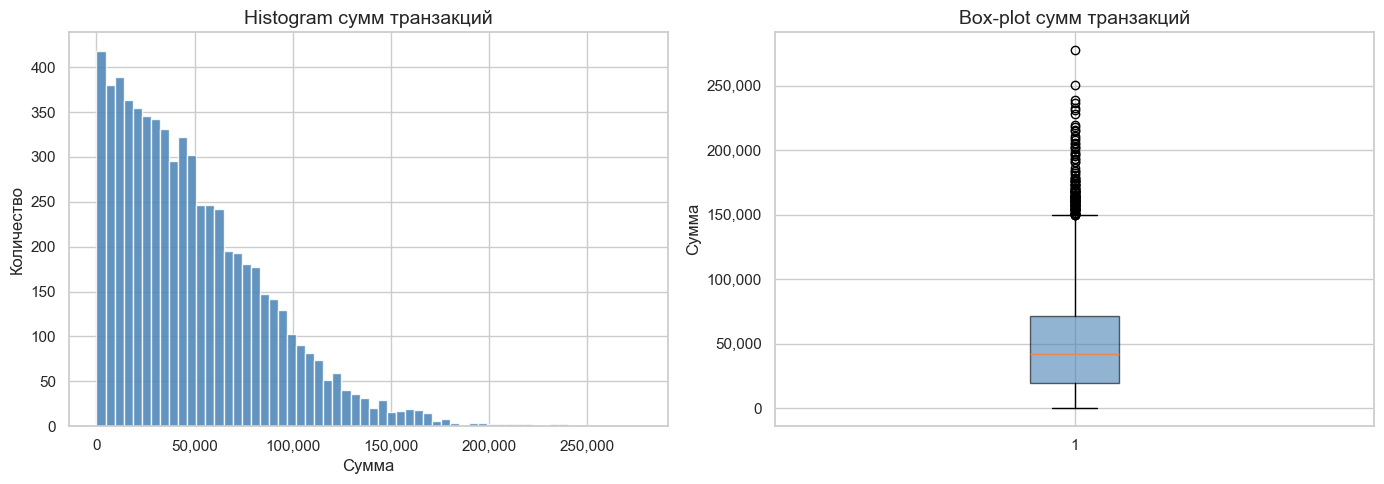

In [107]:
# Распределение сумм транзакций
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(tx['amount'], bins=60, color='steelblue', edgecolor='white', alpha=0.85)
axes[0].set_title('Histogram сумм транзакций', fontsize=14)
axes[0].set_xlabel('Сумма')
axes[0].set_ylabel('Количество')
axes[0].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

axes[1].boxplot(tx['amount'], patch_artist=True,
                boxprops=dict(facecolor='steelblue', alpha=0.6))
axes[1].set_title('Box-plot сумм транзакций', fontsize=14)
axes[1].set_ylabel('Сумма')
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

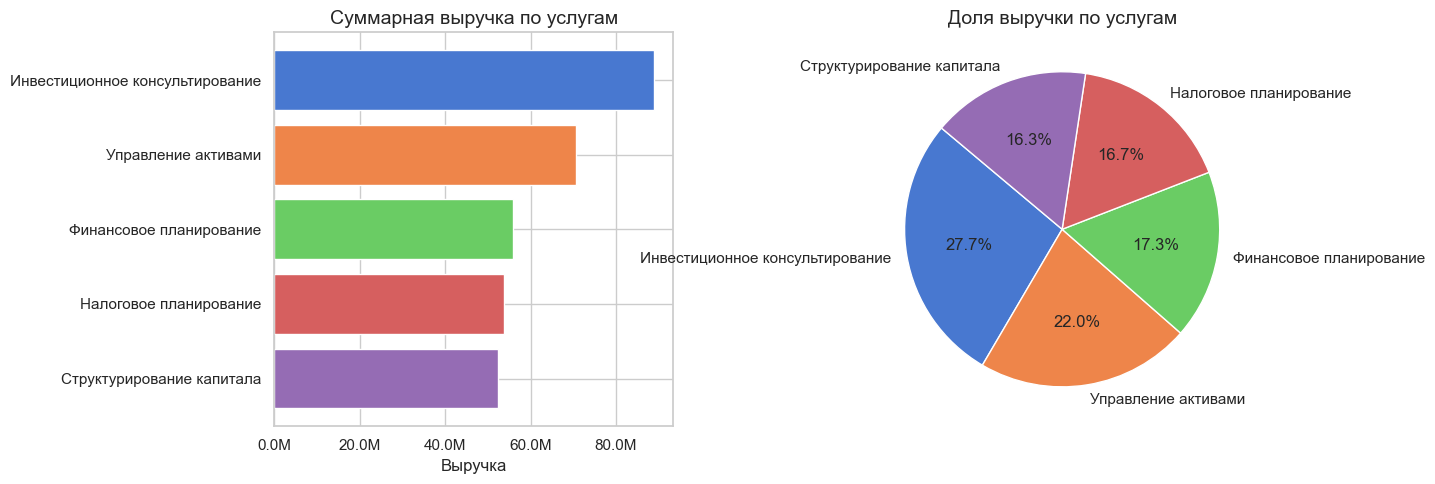

In [70]:
# 6.2 Выручка по услугам
colors = sns.color_palette('muted', len(rev_svc))
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(rev_svc['service'], rev_svc['total_revenue'], color=colors)
axes[0].set_title('Суммарная выручка по услугам', fontsize=14)
axes[0].set_xlabel('Выручка')
axes[0].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
axes[0].invert_yaxis()

axes[1].pie(rev_svc['total_revenue'], labels=rev_svc['service'],
            autopct='%1.1f%%', colors=colors, startangle=140)
axes[1].set_title('Доля выручки по услугам', fontsize=14)

plt.tight_layout()
plt.show()

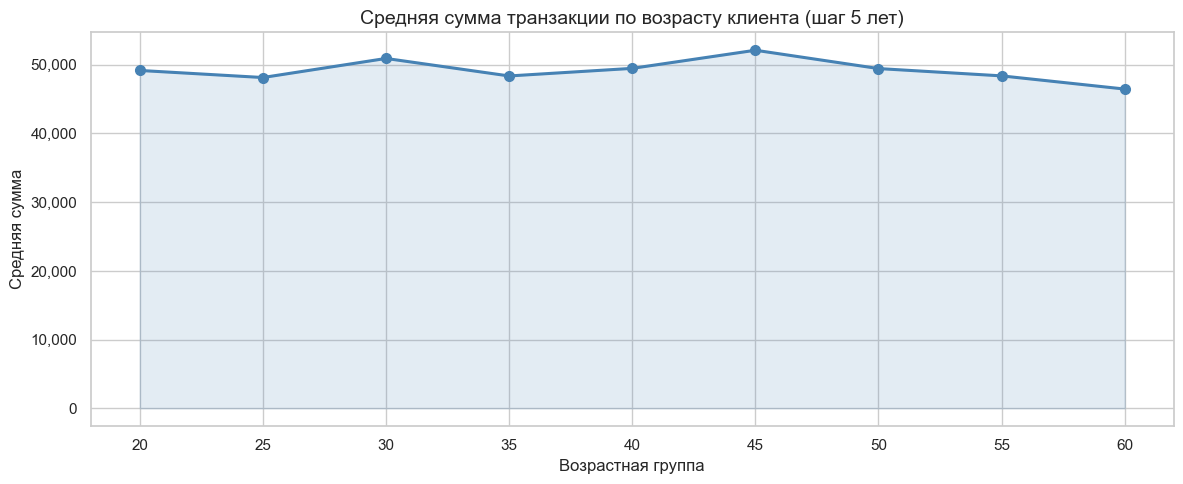

In [108]:
# 6.3 Средняя сумма транзакции по возрасту клиента
age_grp = (merged.dropna(subset=['age', 'amount'])
           .assign(age_bin=lambda d: (d['age'] // 5 * 5).astype(int))
           .groupby('age_bin')['amount']
           .mean()
           .reset_index()
           .rename(columns={'age_bin': 'age_group', 'amount': 'avg_amount'}))

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(age_grp['age_group'], age_grp['avg_amount'],
        marker='o', linewidth=2.2, color='steelblue', markersize=7)
ax.fill_between(age_grp['age_group'], age_grp['avg_amount'], alpha=0.15, color='steelblue')
ax.set_title('Средняя сумма транзакции по возрасту клиента (шаг 5 лет)', fontsize=14)
ax.set_xlabel('Возрастная группа')
ax.set_ylabel('Средняя сумма')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax.xaxis.set_major_locator(mticker.MultipleLocator(5))
plt.tight_layout()
plt.show()

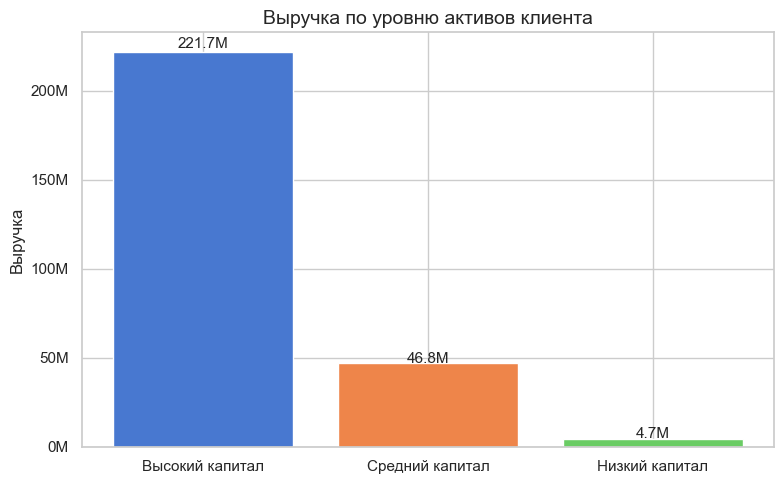

In [109]:
# 6.4 Выручка по уровням активов
wr = wealth_rev.reset_index()
cols = sns.color_palette('muted', len(wr))

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(wr['wealth_category'], wr['total_revenue'], color=cols, edgecolor='white')
for bar, val in zip(bars, wr['total_revenue']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.01,
            f'{val/1e6:.1f}M', ha='center', fontsize=11)
ax.set_title('Выручка по уровню активов клиента', fontsize=14)
ax.set_ylabel('Выручка')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
plt.tight_layout()
plt.show()

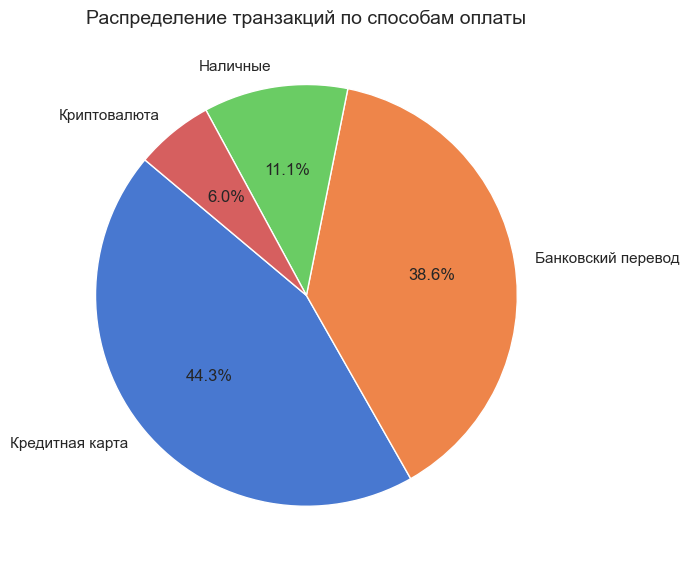

In [73]:
# 6.5 Доля способов оплаты
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(pay_share['share_%'],
       labels=pay_share['payment_method'],
       autopct='%1.1f%%', startangle=140,
       colors=sns.color_palette('muted', len(pay_share)))
ax.set_title('Распределение транзакций по способам оплаты', fontsize=14)
plt.tight_layout()
plt.show()

#### Прогнозирование

In [110]:
# Месячная агрегация
monthly = (tx.set_index('transaction_date')
           .resample('MS')
           .agg(count=('transaction_id', 'count'),
                revenue=('amount', 'sum'))
           .reset_index())
monthly['month_num']   = np.arange(len(monthly))
monthly['month_label'] = monthly['transaction_date'].dt.strftime('%b %Y')
print(monthly[['month_label', 'count', 'revenue']].to_string(index=False))

month_label  count      revenue
   Jan 2025   2559 1.309415e+08
   Feb 2025   2334 1.110817e+08
   Mar 2025   1599 7.963100e+07


In [115]:
X = monthly[['month_num']]

# formula:
# y = intercept + x * slope + constant

lr_cnt = LinearRegression().fit(X, monthly['count'])
lr_rev = LinearRegression().fit(X, monthly['revenue'])

next_num  = monthly['month_num'].max() + 1
next_date = monthly['transaction_date'].max() + pd.DateOffset(months=1)
X_next    = pd.DataFrame({'month_num': [next_num]})

pred_cnt = int(lr_cnt.predict(X_next)[0])
pred_rev = lr_rev.predict(X_next)[0]

print(f'Прогноз на {next_date.strftime("%B %Y")}:')
print(f'Количество транзакций: {pred_cnt:,}')
print(f'Выручка: {pred_rev:,.2f}')
print()
print(f'R² (count) = {r2_score(monthly["count"],   lr_cnt.predict(X)):.3f}')
print(f'R² (revenue) = {r2_score(monthly["revenue"], lr_rev.predict(X)):.3f}')

Прогноз на April 2025:
Количество транзакций: 1,204
Выручка: 55,907,559.07

R² (count) = 0.914
R² (revenue) = 0.983


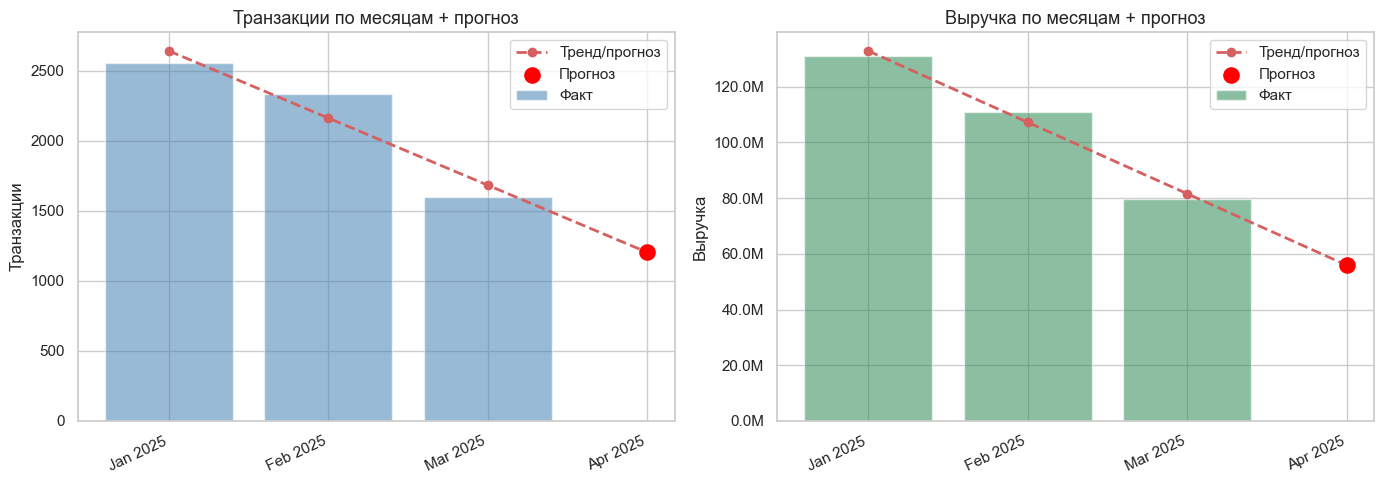

In [114]:
# Визуализация прогноза
all_nums   = list(monthly['month_num']) + [next_num]
all_labels = list(monthly['month_label']) + [next_date.strftime('%b %Y')]
fitted_cnt = lr_cnt.predict(pd.DataFrame({'month_num': all_nums}))
fitted_rev = lr_rev.predict(pd.DataFrame({'month_num': all_nums}))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, y, fitted, label, color in [
    (axes[0], monthly['count'],   fitted_cnt, 'Транзакции', 'steelblue'),
    (axes[1], monthly['revenue'], fitted_rev, 'Выручка',    'seagreen'),
]:
    ax.bar(monthly['month_num'], y, color=color, alpha=0.55, label='Факт')
    ax.plot(all_nums, fitted, 'r--o', linewidth=2, markersize=6, label='Тренд/прогноз')
    ax.scatter([next_num], [fitted[-1]], color='red', s=120, zorder=5, label='Прогноз')
    ax.set_xticks(all_nums)
    ax.set_xticklabels(all_labels, rotation=25, ha='right')
    ax.set_title(f'{label} по месяцам + прогноз', fontsize=13)
    ax.set_ylabel(label)
    ax.legend()
    if label == 'Выручка':
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

#### Final Results

1) 10 000 → 6 492 транзакций после очистки (убраны пропуски, аномалии, дубли)
2) Инвестиционное консультирование лидирует и по количеству, и по выручке (+-89 млн)
3) Кредитная карта основной способ оплаты (44%), банковский перевод на 2-м месте (39%)
4) Высокий капитал приносит 221 млн из +-330 млн суммарной выручки фокус на этом сегменте
5) Данных за 3 месяца (янв–март 2025), прослеживается нисходящий тренд → прогноз на апрель +-55 млн